In [1]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
from imgaug import augmenters as iaa
from torchvision import models
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
import torch.hub

In [3]:
label_encoder = {"Surprise":0, "Fear":1, "Disgust":2, "Happy":3, "Sad":4,
 "Angry":5, "Neutral":6}

In [4]:
inv_enocer = {v:k for k,v in label_encoder.items()}

In [5]:
TRAIN_DATA_PATH = r'../input/rafdb/dataset/aligned/train/train_images'
TRAIN_LABEL_PATH = r'../input/rafdb/dataset/train_labels.csv'
TEST_DATA_PATH = r'../input/rafdb/dataset/aligned/test/test_images'
TEST_LABEL_PATH = r'../input/rafdb/dataset/test_labels.csv'

In [6]:
df = pd.read_csv(TRAIN_LABEL_PATH)
labels = df['label'] - 1

In [7]:
y = [inv_enocer[labels.values[i]] for i in range(len(labels.values))]

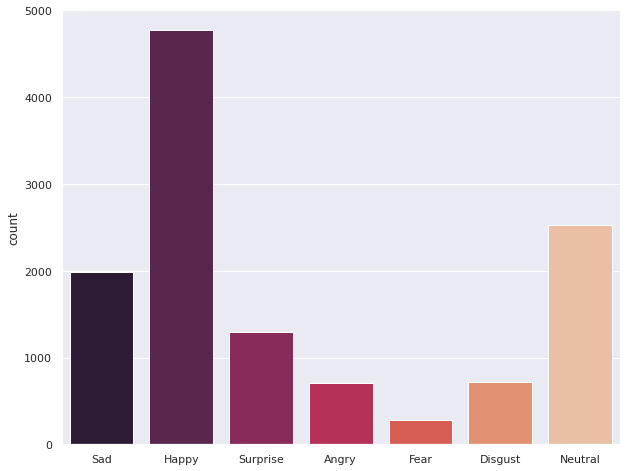

In [8]:
plt.figure(figsize=(10, 8))
sns.countplot(x=y, 
            palette="rocket")
plt.show()

# DataLoader

In [2]:
class FER2013(Dataset):
    def __init__(self, path, aug=None):
        data_pth = []
        labels = []
        label_encoder = {'surprise':0, 'fear':1, 'angry':2, 'neutral':3, 'sad':4, 'disgust':5, 'happy':6}
        for root, file, dirs in os.walk(path):
            if dirs:
                #print(root)
                data_pth.extend(glob(root+'/*.jpg'))
                label = root.split('/')[-1]
                #print(label)
                #print([label_encoder[label]])
                labels.extend([label_encoder[label]]* len(dirs))
                #print(len(dirs))
        
        self.fpath = data_pth
        self.targets = labels
        self.aug = aug
    
    def __getitem__(self, ix):
        ims, y = np.array(Image.open(self.fpath[ix])), self.targets[ix]
        if self.aug: 
            ims = self.aug.augment_image(image=ims)
            
        ims = torch.tensor(np.array([ims, ims, ims])).to(device) / 255.0
        #print(x.shape)
        #ims = ims.permute(2, 0, 1)/255.0
        y = torch.tensor(y, dtype=torch.int64).to(device)
        return ims.float().to(device), y
    
    def __len__(self): return len(self.fpath)

In [3]:
class RAF(Dataset):
    def __init__(self, data_f, label_f, aug=None):
        #self.fpath = glob(data_f + '/*.jpg')
        root = data_f
        df = pd.read_csv(label_f)
        df['image'] = df['image'].apply(lambda x : os.path.join(root, x))
        self.fpath = df['image']
        labels = df['label']
        labels = np.array(labels.values) - 1
        #labels = pd.read_csv(TRAIN_LABEL_PATH)['label']
        self.fpath = self.fpath
        self.targets = labels
        self.aug = aug
        
    def __getitem__(self, ix):
        ims, y = np.array(Image.open(self.fpath[ix])), self.targets[ix]
        if self.aug: ims = self.aug.augment_image(image=ims)
        ims = torch.tensor(ims).to(device)
        ims = ims.permute(2, 0, 1)/255.0
        y = torch.tensor(y, dtype=torch.int64).to(device)
        return ims.float().to(device), y
    def __len__(self): return len(self.fpath)
#     def collate_fn(self, batch):
#         ims, classes = list(zip(*batch))
        
#         ims = torch.tensor(ims).to(device)
#         classes = torch.tensor(classes).to(device)
#         return ims, classes

In [4]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

aug = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        #iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            #pad_mode=iaa.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-10, 10), # rotate by -10 to +10 degrees
            shear=(-5, 5), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 3),
            [
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.95, 1.05)), # sharpen images
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ], random_order=True
        )
    ],
)


## FER2013

In [5]:
def get_FER2013_data():
    TRAIN_DATA_PATH = '../input/fer2013/train'
    TEST_DATA_PATH = '../input/fer2013/test'
    train = FER2013(TRAIN_DATA_PATH, aug=aug)
    trn_dl = DataLoader(train, batch_size=64, shuffle=True, drop_last=True)
    
    test = FER2013(TEST_DATA_PATH)
    test_dl = DataLoader(test, batch_size=64, drop_last=True, shuffle=True)
    
    return trn_dl, test_dl

In [6]:
def get_RAF_data():
    TRAIN_DATA_PATH = r'../input/rafdb/dataset/aligned/train/train_images'
    TRAIN_LABEL_PATH = r'../input/rafdb/dataset/train_labels.csv'
    TEST_DATA_PATH = r'../input/rafdb/dataset/aligned/test/test_images'
    TEST_LABEL_PATH = r'../input/rafdb/dataset/test_labels.csv'
    train = RAF(TRAIN_DATA_PATH, TRAIN_LABEL_PATH, aug=aug)
    trn_dl = DataLoader(train, batch_size=64, shuffle=True, drop_last=True)
    
    test = RAF(TEST_DATA_PATH, TEST_LABEL_PATH)
    test_dl = DataLoader(test, batch_size=64, drop_last=True, shuffle=True)
    
    return trn_dl, test_dl

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### FER2013 Before and After Augmentation

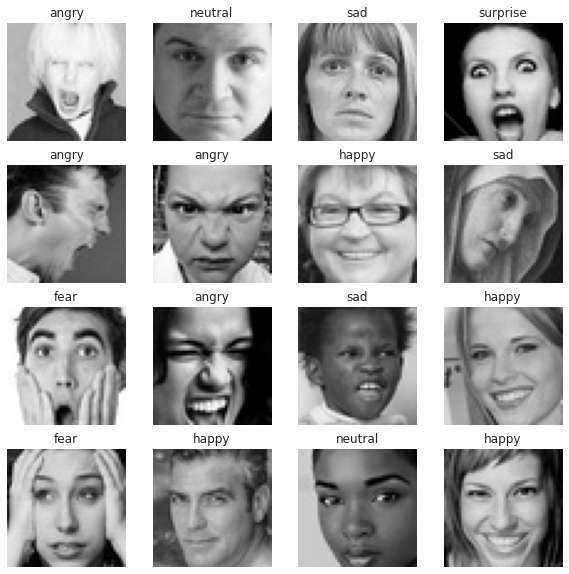

In [8]:
_, test_dl = get_FER2013_data()
label_encoder = {'surprise':0, 'fear':1, 'angry':2, 'neutral':3, 'sad':4, 'disgust':5, 'happy':6}
inv_encoder = {v:k for k,v in label_encoder.items()}
#plt.figure(figsize=(12, 10))
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for x, y in test_dl:
    i = 0
    x = x.permute(0, 2, 3, 1)
    for row in range(4):
        for col in range(4):
            axs[row, col].imshow(x[i].cpu(), cmap='gray')
            
            axs[row, col].set_title(inv_encoder[y[i].cpu().item()])
            axs[row, col].axis('off')
            axs[row, col].grid('off')
            i += 1
    break

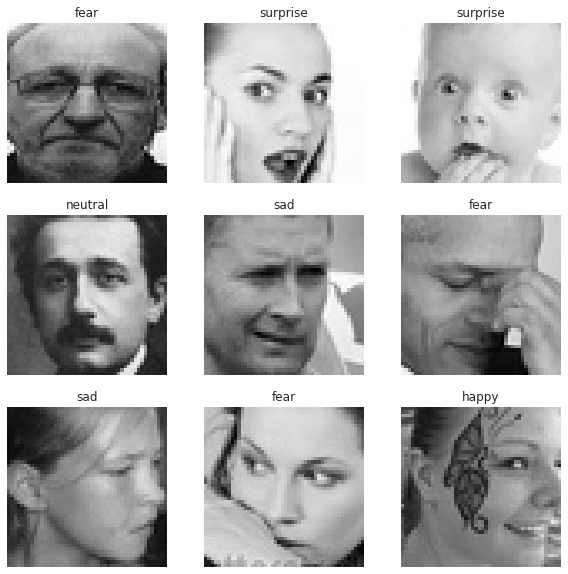

In [11]:
_, test_dl = get_FER2013_data()
label_encoder = {'surprise':0, 'fear':1, 'angry':2, 'neutral':3, 'sad':4, 'disgust':5, 'happy':6}
inv_encoder = {v:k for k,v in label_encoder.items()}
#plt.figure(figsize=(12, 10))
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for x, y in test_dl:
    i = 0
    x = x.permute(0, 2, 3, 1)
    augmented = aug.augment_images(x.cpu().numpy())
    for row in range(3):
        for col in range(3):
            axs[row, col].imshow(x[i].cpu(), cmap='gray')
            
            axs[row, col].set_title(inv_encoder[y[i].cpu().item()])
            axs[row, col].axis('off')
            axs[row, col].grid('off')
            i += 1
    break

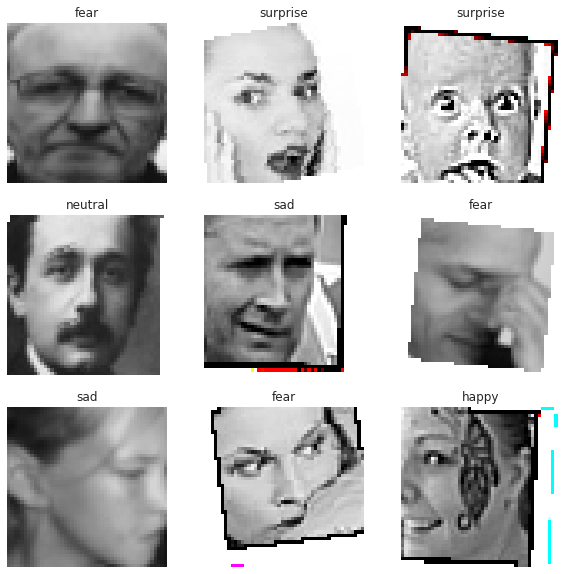

In [12]:
i = 0
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
augmented = aug.augment_images(x.cpu().numpy())
for row in range(3):
    for col in range(3):
        axs[row, col].imshow(augmented[i], cmap='gray')

        axs[row, col].set_title(inv_encoder[y[i].cpu().item()])
        axs[row, col].axis('off')
        axs[row, col].grid('off')
        i += 1

### RAF Before and After Augmentation

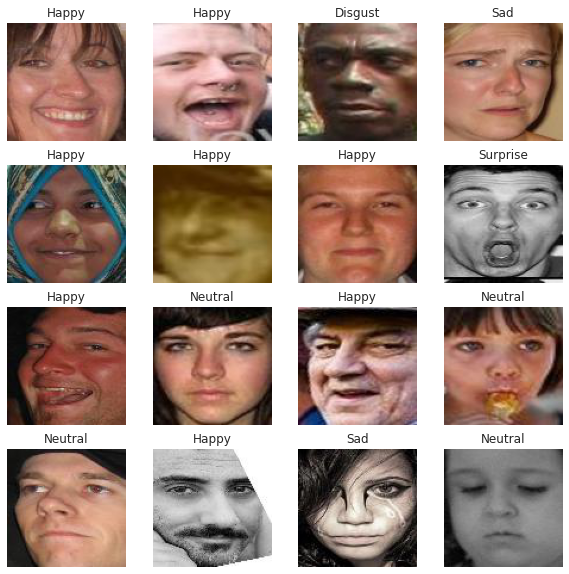

In [13]:
_, test_dl = get_RAF_data()
label_encoder = {"Surprise":0, "Fear":1, "Disgust":2, "Happy":3, "Sad":4,
 "Angry":5, "Neutral":6}
inv_encoder = {v:k for k,v in label_encoder.items()}
#plt.figure(figsize=(12, 10))
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for x, y in test_dl:
    i = 0
    x = x.permute(0, 2, 3, 1)
    for row in range(4):
        for col in range(4):
            axs[row, col].imshow(x[i].cpu())
            
            axs[row, col].set_title(inv_encoder[y[i].cpu().item()])
            axs[row, col].axis('off')
            axs[row, col].grid('off')
            i += 1
    break

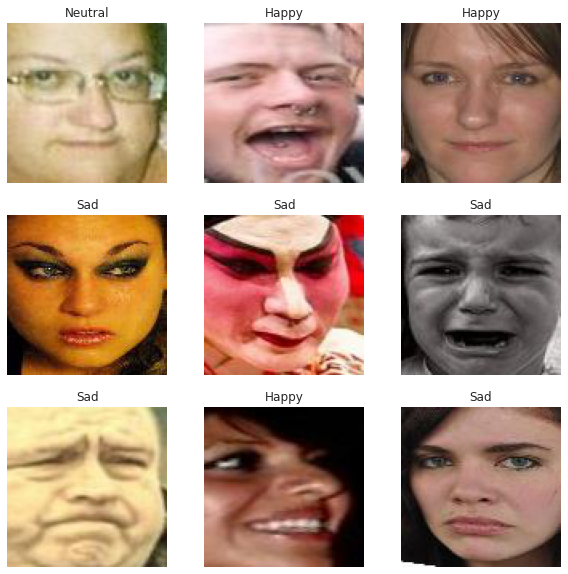

In [14]:
_, test_dl = get_RAF_data()
label_encoder = {"Surprise":0, "Fear":1, "Disgust":2, "Happy":3, "Sad":4,
 "Angry":5, "Neutral":6}
inv_encoder = {v:k for k,v in label_encoder.items()}
#plt.figure(figsize=(12, 10))
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for x, y in test_dl:
    i = 0
    x = x.permute(0, 2, 3, 1)
    augmented = aug.augment_images(x.cpu().numpy())
    for row in range(3):
        for col in range(3):
            axs[row, col].imshow(x[i].cpu())
            
            axs[row, col].set_title(inv_encoder[y[i].cpu().item()])
            axs[row, col].axis('off')
            axs[row, col].grid('off')
            i += 1
    break

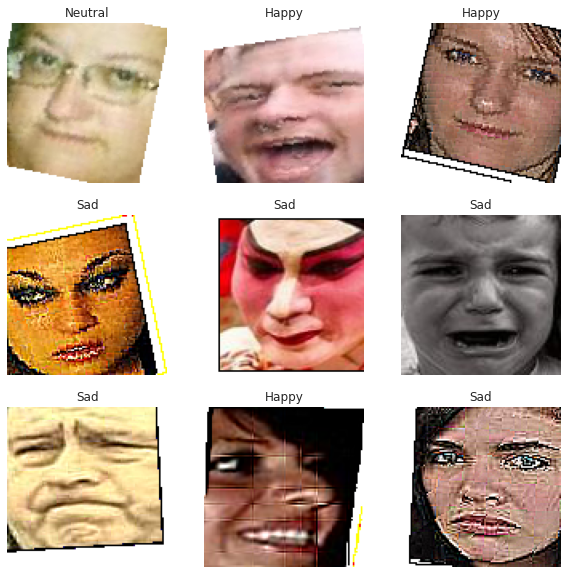

In [15]:
i = 0
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
augmented = aug.augment_images(x.cpu().numpy())
for row in range(3):
    for col in range(3):
        axs[row, col].imshow(augmented[i], cmap='gray')

        axs[row, col].set_title(inv_encoder[y[i].cpu().item()])
        axs[row, col].axis('off')
        axs[row, col].grid('off')
        i += 1

# Model

In [20]:
model_ft = models.wide_resnet50_2(pretrained=True)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [10]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
model_ft.fc = nn.Linear(in_features=512, out_features=7, bias=True)

In [157]:
model_ft.classifier[0] = nn.Linear(in_features=512, out_features=4096)

In [158]:
model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=7, bias=True)

In [13]:
!pip install torchsummary

In [14]:
from torchsummary import summary

In [20]:
def get_model(freezing_layers=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet34(pretrained=True)
    
    if freezing_layers:
        for param in model.parameters():
            param.requires_grad = False
            
    model.fc = nn.Linear(in_features=512, out_features=7, bias=True)
   
    
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.0005)
    return model, loss_fn, optimizer

In [21]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    predictions = np.argmax(model(x).cpu().detach().numpy(), axis=-1)
    #prediction = model(x)
    is_correct = (predictions == y.cpu().numpy())
    return is_correct.tolist()

In [22]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.cpu().item()

In [23]:
model, _, _ = get_model()
summary(model, (3, 48, 48));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           9,408
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
trn_dl, test_dl = get_FER2013_data()
model, loss_fn, optimizer = get_model(freezing_layers=False)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                factor=0.5, patience=7, threshold=0.01,
                 verbose=True, min_lr=3e-5,
                  threshold_mode='abs')

#best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
EPOCHS = 150
for epoch in range(1, EPOCHS+1):
    since = time.time()
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_losses, val_epoch_accuracies = [], []
    print('Epoch {}/{}'.format(epoch, EPOCHS))
    print('-' * 10)
    if epoch == 5:
        print("----Un Freezing----")
        for param in model.parameters():
            param.requires_grad = True
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 2.0
    for ix, batch in enumerate(iter(trn_dl)):
        #print(x.shape)
        x, y = batch
        #print(ix)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        #print(model(x))
        #print(batch_loss)
        train_epoch_losses.append(batch_loss)
    
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_l = val_loss(x, y, model)
        #print(val_l)
        val_epoch_accuracies.extend(val_is_correct)
        val_epoch_losses.append(val_l)
    
    
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    val_epoch_loss = np.mean(val_epoch_losses)
    schedular.step(val_epoch_loss)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    if val_epoch_accuracy > best_acc:
        best_acc = val_epoch_accuracy
        torch.save(model, './best_model.pth')
        print("------Saving-------")
    time_elapsed = time.time()
    phase = 'Train'
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, train_epoch_loss, train_epoch_accuracy))
    
    phase = 'Test'
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, val_epoch_loss, val_epoch_accuracy))
    print(f"Epoch Time {int(time_elapsed - since)}s")
    if epoch % 40 == 0 and epoch != 0:
        i = input("Enter 1 to cointinue training")
        if int(i) != 1:
            print("---___Training Stoped___---")
            break
    #print(f"Epoch {epoch}, train_loss: {train_epoch_loss}, train_acc: {train_epoch_accuracy}, val_loss: {val_epoch_loss}, val_acc: {val_epoch_accuracy}")
        

Epoch 1/150
----------
------Saving-------
Train Loss: 1.4246 Acc: 0.5105
Test Loss: 1.2584 Acc: 0.5187
Epoch Time 293s
Epoch 2/150
----------
------Saving-------
Train Loss: 1.2586 Acc: 0.5506
Test Loss: 1.1585 Acc: 0.5562
Epoch Time 177s
Epoch 3/150
----------
------Saving-------
Train Loss: 1.1839 Acc: 0.5534
Test Loss: 1.1593 Acc: 0.5626
Epoch Time 177s
Epoch 4/150
----------
------Saving-------
Train Loss: 1.1474 Acc: 0.5863
Test Loss: 1.0950 Acc: 0.5841
Epoch Time 176s
Epoch 5/150
----------
----Un Freezing----
------Saving-------
Train Loss: 1.0588 Acc: 0.6182
Test Loss: 1.0169 Acc: 0.6198
Epoch Time 177s
Epoch 6/150
----------
------Saving-------
Train Loss: 1.0263 Acc: 0.6212
Test Loss: 1.0135 Acc: 0.6225
Epoch Time 176s
Epoch 7/150
----------
------Saving-------
Train Loss: 1.0153 Acc: 0.6327
Test Loss: 1.0023 Acc: 0.6250
Epoch Time 180s
Epoch 8/150
----------
------Saving-------
Train Loss: 0.9934 Acc: 0.6453
Test Loss: 0.9822 Acc: 0.6332
Epoch Time 178s
Epoch 9/150
--------

Enter 1 to cointinue training 0


---___Training Stoped___---


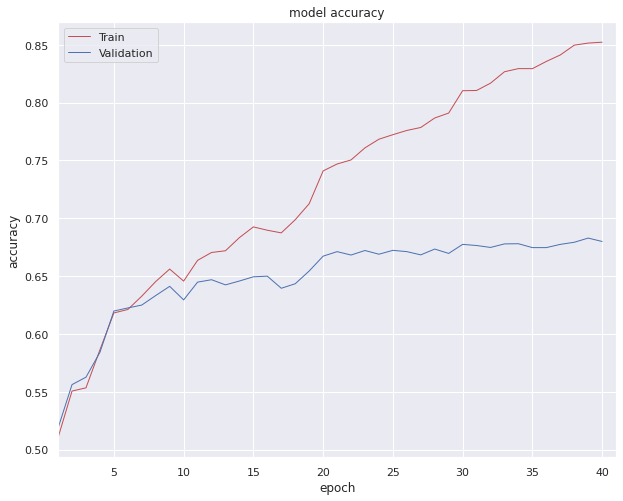

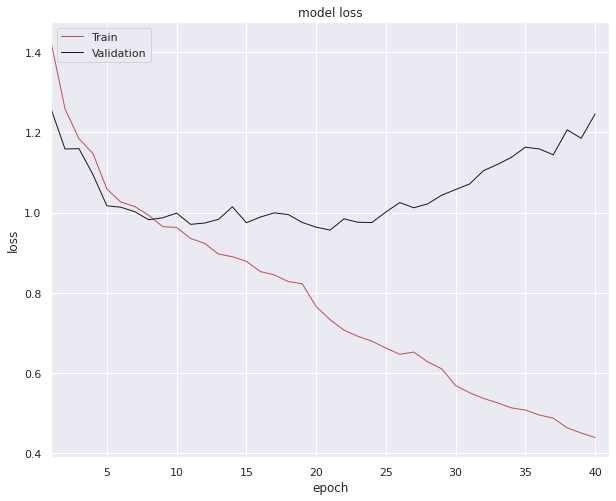

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 41),train_accuracies, 'r', linewidth=1)
plt.plot(range(1, 41),val_accuracies, 'b', linewidth=1)
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid("on")
plt.xlim([1, 41])
plt.show()
# summarize history for loss
plt.figure(figsize=(10, 8))
plt.plot(range(1, 41),train_losses, 'r', linewidth=1)
plt.plot(range(1, 41),val_losses, 'k', linewidth=1)
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim([1, 41])
#plt.legend(['train', 'test'], loc='upper left')
plt.grid("on")
plt.show()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_ft, _, _ = get_model()
#model_ft.load_state_dict(torch.load('../input/my-model/best_model.pth'))
#model_ft.load(device)
model = torch.load('./best_model.pth')
model.eval()
#model
trn_dl, test_dl = get_FER2013_data()
predictions = []
labels = []
for ix, batch in enumerate(iter(test_dl)):
    x, y = batch
    #print(len(x))
    labels.extend(y.cpu().detach().numpy())
    predictions.extend(model(x).cpu().detach().numpy())

In [29]:
import seaborn as sns
sns.set_theme()

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [31]:
label_encoder = {'surprise':0, 'fear':1, 'angry':2, 'neutral':3, 'sad':4, 'disgust':5, 'happy':6}
reverse_encoder = {k:v for v, k in label_encoder.items()}

In [32]:
y_pred = np.argmax(np.array(predictions), axis=-1)

In [33]:
con = confusion_matrix(y_pred, labels)

In [34]:
con2 = np.array(con)/np.sum(con, axis=1, keepdims=True)
con2

array([[7.84090909e-01, 8.86363636e-02, 2.95454545e-02, 2.72727273e-02,
        2.84090909e-02, 0.00000000e+00, 4.20454545e-02],
       [5.73593074e-02, 5.57359307e-01, 1.16883117e-01, 8.65800866e-02,
        1.60173160e-01, 1.08225108e-03, 2.05627706e-02],
       [2.04081633e-02, 1.23523093e-01, 5.92910849e-01, 6.98174006e-02,
        1.27819549e-01, 2.47046187e-02, 4.08163265e-02],
       [1.43288084e-02, 7.01357466e-02, 7.61689291e-02, 6.20663650e-01,
        1.50829563e-01, 3.77073906e-03, 6.41025641e-02],
       [1.59798150e-02, 1.50546678e-01, 9.75609756e-02, 1.27838520e-01,
        5.74432296e-01, 4.20521447e-03, 2.94365013e-02],
       [9.61538462e-03, 1.92307692e-02, 1.34615385e-01, 1.92307692e-02,
        6.73076923e-02, 7.30769231e-01, 1.92307692e-02],
       [1.65380375e-02, 2.14994487e-02, 2.20507166e-02, 4.57552370e-02,
        3.58324146e-02, 5.51267916e-04, 8.57772878e-01]])

In [35]:
con

array([[ 690,   78,   26,   24,   25,    0,   37],
       [  53,  515,  108,   80,  148,    1,   19],
       [  19,  115,  552,   65,  119,   23,   38],
       [  19,   93,  101,  823,  200,    5,   85],
       [  19,  179,  116,  152,  683,    5,   35],
       [   1,    2,   14,    2,    7,   76,    2],
       [  30,   39,   40,   83,   65,    1, 1556]])

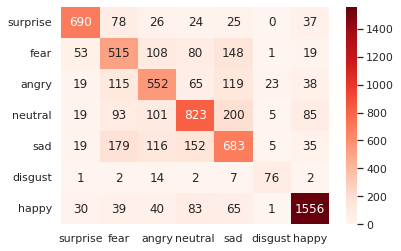

In [36]:
sns.heatmap(con, annot=True,fmt="d",cmap='Reds', xticklabels=list(label_encoder.keys()), yticklabels=list(label_encoder.keys()))
plt.show()

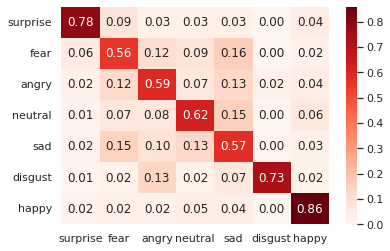

In [37]:
sns.heatmap(con2, annot=True,fmt=".2f",cmap='Reds', xticklabels=list(label_encoder.keys()), yticklabels=list(label_encoder.keys()))
plt.show()

In [38]:
print(classification_report(labels, y_pred, target_names=list(label_encoder.keys())))

              precision    recall  f1-score   support

    surprise       0.78      0.83      0.81       831
        fear       0.56      0.50      0.53      1021
       angry       0.59      0.58      0.58       957
     neutral       0.62      0.67      0.64      1229
         sad       0.57      0.55      0.56      1247
     disgust       0.73      0.68      0.71       111
       happy       0.86      0.88      0.87      1772

    accuracy                           0.68      7168
   macro avg       0.67      0.67      0.67      7168
weighted avg       0.68      0.68      0.68      7168



In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
trn_dl, test_dl = get_RAF_data()
model, loss_fn, optimizer = get_model(freezing_layers=False)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                factor=0.4, patience=5, threshold=0.001,
                 verbose=True, min_lr=3e-6,
                  threshold_mode='abs')

#best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
EPOCHS = 150
for epoch in range(1, EPOCHS+1):
    since = time.time()
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_losses, val_epoch_accuracies = [], []
    print('Epoch {}/{}'.format(epoch, EPOCHS))
    print('-' * 10)
    if epoch == 5:
        print("----Un Freezing----")
        for param in model.parameters():
            param.requires_grad = True
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 2.0
    for ix, batch in enumerate(iter(trn_dl)):
        #print(x.shape)
        x, y = batch
        #print(ix)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        #print(model(x))
        #print(batch_loss)
        train_epoch_losses.append(batch_loss)
    
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_l = val_loss(x, y, model)
        #print(val_l)
        val_epoch_accuracies.extend(val_is_correct)
        val_epoch_losses.append(val_l)
    
    
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    val_epoch_loss = np.mean(val_epoch_losses)
    schedular.step(val_epoch_loss)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    if val_epoch_accuracy > best_acc:
        best_acc = val_epoch_accuracy
        torch.save(model, './best_model_RAF.pth')
        print("------Saving-------")
    time_elapsed = time.time()
    phase = 'Train'
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, train_epoch_loss, train_epoch_accuracy))
    
    phase = 'Test'
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, val_epoch_loss, val_epoch_accuracy))
    print(f"Epoch Time {int(time_elapsed - since)}s")
    if epoch % 40 == 0 and epoch != 0:
        i = input("Enter 1 to cointinue training")
        if int(i) != 1:
            print("---___Training Stoped___---")
            break
    #print(f"Epoch {epoch}, train_loss: {train_epoch_loss}, train_acc: {train_epoch_accuracy}, val_loss: {val_epoch_loss}, val_acc: {val_epoch_accuracy}")
        

Epoch 1/150
----------
------Saving-------
Train Loss: 1.0331 Acc: 0.6553
Test Loss: 1.0030 Acc: 0.6715
Epoch Time 212s
Epoch 2/150
----------
------Saving-------
Train Loss: 0.7465 Acc: 0.7583
Test Loss: 0.6813 Acc: 0.7517
Epoch Time 92s
Epoch 3/150
----------
------Saving-------
Train Loss: 0.6572 Acc: 0.7776
Test Loss: 0.6245 Acc: 0.7779
Epoch Time 93s
Epoch 4/150
----------
Train Loss: 0.6026 Acc: 0.7550
Test Loss: 0.6709 Acc: 0.7656
Epoch Time 92s
Epoch 5/150
----------
----Un Freezing----
------Saving-------
Train Loss: 0.4913 Acc: 0.8495
Test Loss: 0.4961 Acc: 0.8278
Epoch Time 92s
Epoch 6/150
----------
Train Loss: 0.4486 Acc: 0.8184
Test Loss: 0.6011 Acc: 0.7779
Epoch Time 91s
Epoch 7/150
----------
Train Loss: 0.4206 Acc: 0.8519
Test Loss: 0.5209 Acc: 0.8238
Epoch Time 91s
Epoch 8/150
----------
Train Loss: 0.4008 Acc: 0.8563
Test Loss: 0.5328 Acc: 0.8095
Epoch Time 91s
Epoch 9/150
----------
------Saving-------
Train Loss: 0.3842 Acc: 0.8835
Test Loss: 0.4657 Acc: 0.8331
Epo

Enter 1 to cointinue training 0


---___Training Stoped___---


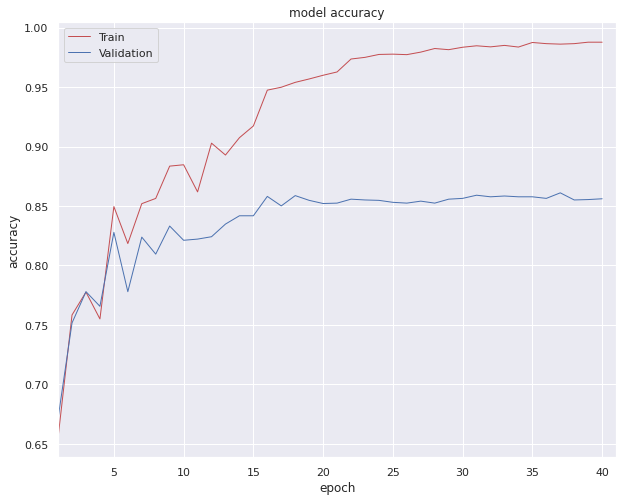

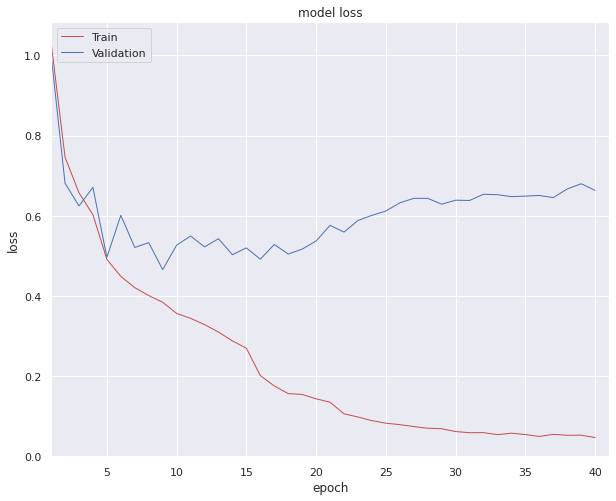

In [40]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 41),train_accuracies, 'r', linewidth=1)
plt.plot(range(1, 41),val_accuracies, 'b', linewidth=1)
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid("on")
plt.xlim([1, 41])
plt.show()
# summarize history for loss
plt.figure(figsize=(10, 8))
plt.plot(range(1, 41),train_losses, 'r', linewidth=1)
plt.plot(range(1, 41),val_losses, 'b', linewidth=1)
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim([1, 41])
#plt.legend(['train', 'test'], loc='upper left')
plt.grid("on")
plt.show()

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_ft, _, _ = get_model()
#model_ft.load_state_dict(torch.load('../input/my-model/best_model.pth'))
#model_ft.load(device)
model = torch.load('./best_model_RAF.pth')
model.eval()
#model
trn_dl, test_dl = get_RAF_data()
predictions = []
labels = []
for ix, batch in enumerate(iter(test_dl)):
    x, y = batch
    #print(len(x))
    labels.extend(y.cpu().detach().numpy())
    predictions.extend(model(x).cpu().detach().numpy())

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.set_theme()

In [43]:
y_pred = np.argmax(np.array(predictions), axis=-1)

In [44]:
con = confusion_matrix(y_pred, labels)

In [45]:
con

array([[ 272,   10,    2,    5,    1,    6,   12],
       [  10,   41,    3,    4,    4,    5,    2],
       [   2,    2,   93,   13,   10,    7,   15],
       [   9,    4,    7, 1081,   15,    7,   28],
       [   6,    9,   20,   10,  406,    3,   46],
       [   4,    3,   15,    7,    4,  129,    6],
       [  16,    3,   17,   39,   30,    3,  562]])

In [46]:
con2 = np.array(con)/np.sum(con, axis=1, keepdims=True)
con2

array([[0.88311688, 0.03246753, 0.00649351, 0.01623377, 0.00324675,
        0.01948052, 0.03896104],
       [0.14492754, 0.5942029 , 0.04347826, 0.05797101, 0.05797101,
        0.07246377, 0.02898551],
       [0.01408451, 0.01408451, 0.65492958, 0.0915493 , 0.07042254,
        0.04929577, 0.1056338 ],
       [0.00781929, 0.00347524, 0.00608167, 0.93918332, 0.01303215,
        0.00608167, 0.02432667],
       [0.012     , 0.018     , 0.04      , 0.02      , 0.812     ,
        0.006     , 0.092     ],
       [0.02380952, 0.01785714, 0.08928571, 0.04166667, 0.02380952,
        0.76785714, 0.03571429],
       [0.0238806 , 0.00447761, 0.02537313, 0.05820896, 0.04477612,
        0.00447761, 0.83880597]])

In [47]:
label_encoder = {'surprise':0, 'fear':1, 'angry':2, 'neutral':3, 'sad':4, 'disgust':5, 'happy':6}


In [48]:
label_encoder = {"Surprise":0, "Fear":1, "Disgust":2, "Happy":3, "Sad":4,
 "Angry":5, "Neutral":6}

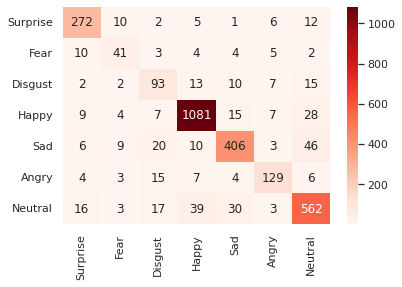

In [49]:
sns.heatmap(con, annot=True,fmt="d",cmap='Reds', xticklabels=list(label_encoder.keys()), yticklabels=list(label_encoder.keys()))
plt.show()

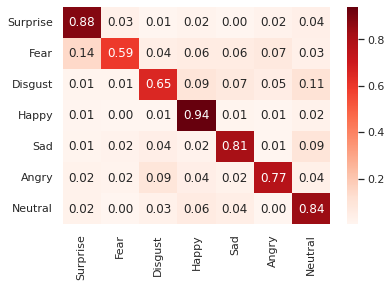

In [50]:
sns.heatmap(con2, annot=True,fmt=".2f",cmap='Reds', xticklabels=list(label_encoder.keys()), yticklabels=list(label_encoder.keys()))
plt.show()

In [51]:
print(classification_report(labels, y_pred, target_names=list(label_encoder.keys())))

              precision    recall  f1-score   support

    Surprise       0.88      0.85      0.87       319
        Fear       0.59      0.57      0.58        72
     Disgust       0.65      0.59      0.62       157
       Happy       0.94      0.93      0.94      1159
         Sad       0.81      0.86      0.84       470
       Angry       0.77      0.81      0.79       160
     Neutral       0.84      0.84      0.84       671

    accuracy                           0.86      3008
   macro avg       0.78      0.78      0.78      3008
weighted avg       0.86      0.86      0.86      3008

